In [1]:
import torch

C_xy = torch.load('/lustre/mlnvme/data/s94zalek_hpc-shape_matching/SURREAL/train/SURREAL_evecs_10_augShapes_signNet_remeshed_mass_6b_1ev_10_0.2_0.8/train/C_gt_xy_0_10952.pt')
C_yx = torch.load('/lustre/mlnvme/data/s94zalek_hpc-shape_matching/SURREAL/train/SURREAL_evecs_10_augShapes_signNet_remeshed_mass_6b_1ev_10_0.2_0.8/train/C_gt_yx_0_10952.pt')

cond_second = torch.load('/lustre/mlnvme/data/s94zalek_hpc-shape_matching/SURREAL/train/SURREAL_evecs_10_augShapes_signNet_remeshed_mass_6b_1ev_10_0.2_0.8/train/evecs_cond_second_0_10952.pt')

evecs_first_with_corr = torch.load('/lustre/mlnvme/data/s94zalek_hpc-shape_matching/SURREAL/train/SURREAL_evecs_10_augShapes_signNet_remeshed_mass_6b_1ev_10_0.2_0.8/train/evecs_first_with_corr_0_10952.pt',
                                   mmap=True)
evecs_second_with_corr = torch.load('/lustre/mlnvme/data/s94zalek_hpc-shape_matching/SURREAL/train/SURREAL_evecs_10_augShapes_signNet_remeshed_mass_6b_1ev_10_0.2_0.8/train/evecs_second_with_corr_0_10952.pt',
                                    mmap=True)

In [9]:
curr_idx = 6000

In [10]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
C_xy_evecs = torch.linalg.lstsq(evecs_second_with_corr[curr_idx].to(device), evecs_first_with_corr[curr_idx].to(device)).solution.cpu()
C_yx_evecs = torch.linalg.lstsq(evecs_first_with_corr[curr_idx].to(device), evecs_second_with_corr[curr_idx].to(device)).solution.cpu()

In [ ]:
(C_xy_evecs - C_xy[curr_idx]).abs().sum(), (C_yx_evecs - C_yx[curr_idx]).abs().sum()

In [ ]:
import my_code.utils.plotting_utils as plotting_utils
import matplotlib.pyplot as plt


l = 0
h = 32

fig, axs = plt.subplots(1, 4, figsize=(15, 4))

plotting_utils.plot_Cxy(fig, axs[0],  C_xy[curr_idx],
                        'before', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], C_xy_evecs,
                        'before', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], C_xy_evecs - C_xy[curr_idx],
                        'before', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[3], cond_second[curr_idx],
                        'before', l, h, show_grid=False, show_colorbar=False)
plt.show()

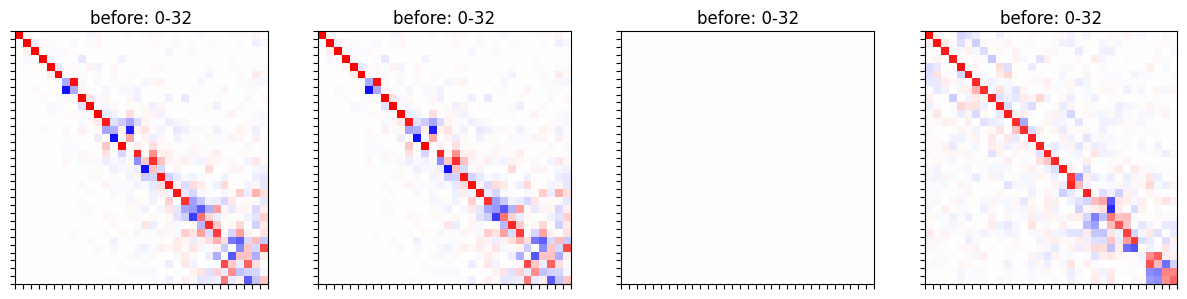

# Generate pairwise fmaps

In [2]:
evecs_second_with_corr = torch.load('/lustre/mlnvme/data/s94zalek_hpc-shape_matching/SURREAL/train/SURREAL_evecs_10_augShapes_signNet_remeshed_mass_6b_1ev_10_0.2_0.8/train/evecs_second_with_corr_0_10952.pt',
                                    mmap=False)

In [ ]:
evecs_second_with_corr.shape

In [ ]:
from tqdm import tqdm

n_pairs = 10

# C_xy_evecs_tensor = torch.tensor([])
C_xy_evecs_list = []

# C_xy_evecs_tensor = torch.zeros((n_pairs * evecs_second_with_corr.shape[0], evecs_second_with_corr.shape[2], evecs_second_with_corr.shape[2]))
# print('Memory allocated', C_xy_evecs_tensor.shape)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

for first_idx in tqdm(range(evecs_second_with_corr.shape[0])):
    evecs_first = evecs_second_with_corr[first_idx]
    
    for curr_pair in range(n_pairs):
        
        second_idx = torch.randint(evecs_second_with_corr.shape[0], (1,)).item()
        while second_idx == first_idx:
            second_idx = torch.randint(evecs_second_with_corr.shape[0], (1,)).item()
            
        # print(first_idx, second_idx)
        
        evecs_second = evecs_second_with_corr[second_idx]
        
        C_xy_evecs = torch.linalg.lstsq(
            evecs_second.to(device),
            evecs_first.to(device)
            ).solution.cpu()
        
        # C_xy_evecs_tensor[first_idx * n_pairs + curr_pair] = C_xy_evecs
        
        # print(first_idx * n_pairs + curr_pair)
        
        # C_xy_evecs_tensor = torch.cat((C_xy_evecs_tensor, C_xy_evecs.unsqueeze(0)), dim=0)
        C_xy_evecs_list.append(C_xy_evecs)
        
C_xy_evecs_tensor = torch.stack(C_xy_evecs_list, dim=0)
C_xy_evecs_tensor.shape

preallocate: 2 min 

list: 1.5 min

In [ ]:
# get the size of C_xy_evecs_tensor in GB
21*4*C_xy_evecs_tensor.element_size() * C_xy_evecs_tensor.nelement() / 1e9